# Phase 5 — Deep Learning Model Development

Train improved deep learning models:
1. **FFNN with Residual Connections** - Better gradient flow
2. **CNN with Stability Improvements** - Learning rate scheduling, early stopping
3. **Autoencoder** - Anomaly detection (unchanged)

**Removed LSTM**: Too slow (~7.5+ hrs training) for minimal accuracy gains on tabular data.
Use gradient boosting or TabNet for sequential patterns instead.

In [12]:
from tqdm import tqdm
import sys
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, BatchNormalization, Input, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import psutil
import gc
import time

print("Libraries successfully loaded")

Libraries successfully loaded


In [2]:
# ===================================================================
# Memory Optimization Utilities
# ===================================================================


def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3

def optimize_dtypes(df):
    """Reduce memory usage by optimizing data types"""
    print("\nOptimizing data types...")
    start_mem = df.memory_usage(deep=True).sum() / 1024**3
    print(f"  Initial memory: {start_mem:.2f} GB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**3
    saved = start_mem - end_mem
    print(f"  Final memory: {end_mem:.2f} GB")
    print(f"  Saved: {saved:.2f} GB ({100 * saved / start_mem:.1f}%)")
    
    return df

print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.2f} GB")

System RAM: 15.7 GB
Available RAM: 5.2 GB
Current process memory: 0.37 GB


In [ ]:
# Load or Define Focal Loss for Deep Learning
DATA_DIR = Path("../data/processed/ml_balance")
try:
    sys.path.append(str(DATA_DIR))
    from focal_loss import focal_loss
    print("Focal Loss imported successfully")
except ImportError:
    print("focal_loss module not found, defining inline...")
    import tensorflow as tf
    from tensorflow.keras import backend as K
    def focal_loss(gamma=2.0, alpha=0.25):
        """
        Focal loss for multi-class classification
        """
        def focal_loss_fixed(y_true, y_pred):
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
            cross_entropy = -y_true * K.log(y_pred)
            loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
            return K.sum(loss, axis=-1)
        
        return focal_loss_fixed

use_balanced = available_mem < 4.0  # Use balanced if low memory

if use_balanced:
    X = pd.read_csv(DATA_DIR / "train_balanced.csv", dtype=np.float32).values
    y = pd.read_csv(DATA_DIR / "train_balanced_labels.csv", dtype=np.int16).values
else:
    X = pd.read_csv(DATA_DIR / "train_original.csv", dtype=np.float32, nrows=5000000).values
    y = pd.read_csv(DATA_DIR / "train_original_labels.csv", dtype=np.int16, nrows=5000000).values
if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
    y = y.ravel()
elif len(y.shape) > 1:
    y = y.ravel()

print(f"\nTraining data shape: {X.shape}")
print(f"Memory usage: {get_memory_usage():.2f} GB")

Focal Loss imported successfully

Available memory: 5.16 GB

Using ORIGINAL training data with Focal Loss...
Loading subset of original data (first 5M samples for speed)...
Subset loaded for faster iteration

Training data shape: (5000000, 37)
Memory usage: 1.08 GB


In [4]:
# Keep test set aside for final evaluation
X_test = pd.read_csv(DATA_DIR / "test.csv", dtype=np.float32).values
y_test = pd.read_csv(DATA_DIR / "test_labels.csv", dtype=np.int16).values
if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
    y_test = y_test.ravel()
elif len(y_test.shape) > 1:
    y_test = y_test.ravel()

num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

In [ ]:
MODEL_DIR = Path("../trained_models/dl_models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Deep learning models will be saved to {MODEL_DIR}")
def get_callbacks(model_name, use_lr_scheduler=False):
    """
    Get training callbacks.
    Args: model_name: Name for the model checkpoint file, use_lr_scheduler: If True, skip ReduceLROnPlateau (for models with LR schedules)
    """
    callbacks_list = [
        EarlyStopping(
            monitor='val_loss', 
            patience=5,  # Reduced from 7 for faster iteration
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            MODEL_DIR / f"{model_name}_best.keras",
            monitor='val_loss',
            save_best_only=True,
            verbose=0
        )
    ]
    if not use_lr_scheduler:
        callbacks_list.insert(1, ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=2,  # Reduced from 3 for faster adaptation
            min_lr=1e-7,
            verbose=1
        ))
    return callbacks_list


Train shape: (4000000, 37), Val shape: (1000000, 37)
Test shape: (9337316, 37)
Number of classes: 34
Using Focal Loss (gamma=2.0, alpha=0.25) for class imbalance
Deep learning models will be saved to ..\trained_models\dl_models

Fast training mode enabled:
  Early stopping patience: 5 epochs
  Learning rate reduction patience: 2 epochs (for models without LR schedules)
  Larger batch sizes for faster training
  Fewer epochs with early stopping


In [ ]:
# FFNN with Residual Connections (Fast Training Mode)
print("FFNN with Residual Connections + Focal Loss ")
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# First block
x = Dense(512, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Residual block 1
residual = Dense(256)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Residual connection
x = Dropout(0.3)(x)

# Residual block 2
residual = Dense(128)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Residual connection
x = Dropout(0.2)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

ffnn_residual = Model(input_layer, output, name='FFNN_Residual')

# Compile with Focal Loss and higher learning rate for faster convergence
ffnn_residual.compile(
    optimizer=Adam(learning_rate=2e-3),  # Increased from 1e-3 for faster training
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print(ffnn_residual.summary())
print("\nUsing Focal Loss (gamma=2.0, alpha=0.25) for class imbalance")
print("Fast mode: Higher learning rate, larger batch size, early stopping")


train_start = time.time()

history_ffnn = ffnn_residual.fit(
    X_train, y_train,
    epochs=30,  # Reduced from 50, early stopping will find optimal
    batch_size=512,  # Increased from 256 for faster training
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('ffnn_residual'),
    verbose=1
)

train_time = time.time() - train_start
print(f"\nTraining completed in {train_time/60:.1f} minutes")

ffnn_residual.save(MODEL_DIR / "final_ffnn_residual.keras")
print(f"Saved to {MODEL_DIR / 'final_ffnn_residual.keras'}")

# Free memory
del ffnn_residual
gc.collect()

FFNN with Residual Connections + Focal Loss (FAST MODE)


Model: "FFNN_Residual"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     19,456 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 34)        │      4,386 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,874 (1.36 MB)

 Trainable params: 354,082 (1.35 MB)

 Non-trainable params: 1,792 (7.00 KB)

None

Using Focal Loss (gamma=2.0, alpha=0.25) for class imbalance
Fast mode: Higher learning rate, larger batch size, early stopping
Epoch 1/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 228s 21ms/step - accuracy: 0.8161 - loss: 0.0440 - val_accuracy: 0.7909 - val_loss: 0.0439 - learning_rate: 0.0020
Epoch 2/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 152s 19ms/step - accuracy: 0.8429 - loss: 0.0359 - val_accuracy: 0.8613 - val_loss: 0.0325 - learning_rate: 0.0020
Epoch 3/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 194s 18ms/step - accuracy: 0.8502 - loss: 0.0343 - val_accuracy: 0.8627 - val_loss: 0.0329 - learning_rate: 0.0020
Epoch 4/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 145s 19ms/step - accuracy: 0.8540 - loss: 0.0337 - val_accuracy: 0.8615 - val_loss: 0.0317 - learning_rate: 0.0020
Epoch 5/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - accuracy: 0.8579 - loss: 0.0329 - val_accuracy: 0.8564 - val_loss: 0.0314 - learning_rate: 0.0020
Epoch 6/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 140s 18ms/step - accuracy: 0.8601 - los

2021

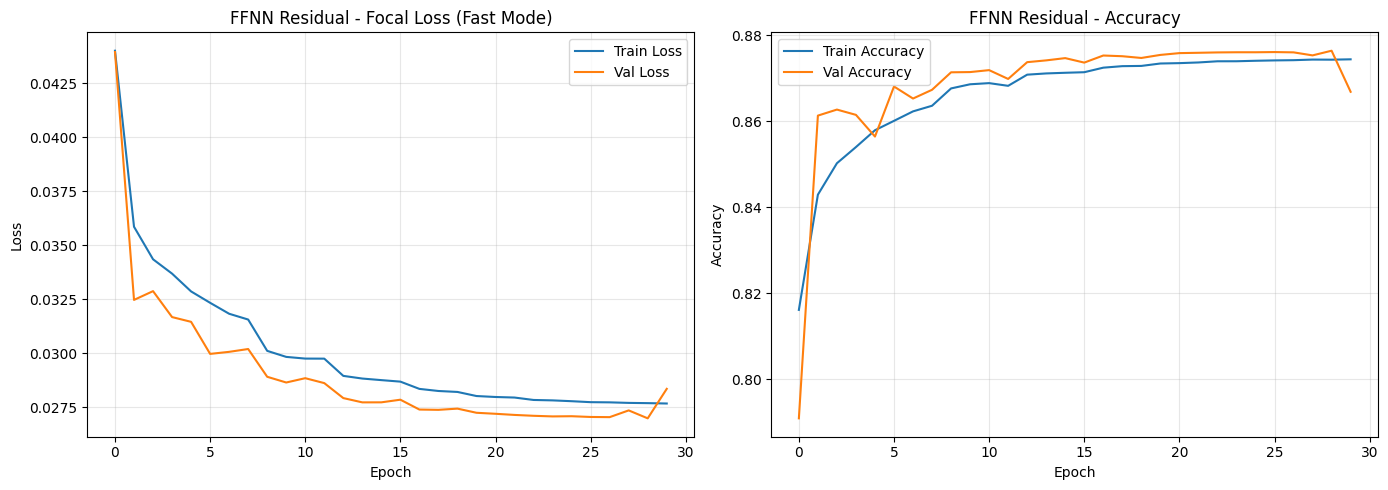

Total epochs trained: 30
Best validation loss: 0.0270


In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ffnn.history['loss'], label='Train Loss')
axes[0].plot(history_ffnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('FFNN Residual - Focal Loss (Fast Mode)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_ffnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_ffnn.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('FFNN Residual - Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total epochs trained: {len(history_ffnn.history['loss'])}")
print(f"Best validation loss: {min(history_ffnn.history['val_loss']):.4f}")

In [6]:
# ============================================================
# CNN with Improved Stability (Fast Training Mode)
# ============================================================
print("=" * 60)
print("CNN with Stability Improvements + Focal Loss (FAST MODE)")
print("=" * 60)

# Load model back for evaluation if freed from memory
if 'ffnn_residual' not in dir():
    ffnn_residual = load_model(MODEL_DIR / "final_ffnn_residual.keras", 
                               custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})

X_train_cnn = np.expand_dims(X_train, -1)
X_val_cnn = np.expand_dims(X_val, -1)
X_test_cnn = np.expand_dims(X_test, -1)

# Use cosine decay learning rate schedule with higher initial rate
initial_learning_rate = 2e-3  # Increased from 1e-3
decay_steps = len(X_train_cnn) // 512 * 20  # 20 epochs worth (reduced from 30)
lr_schedule = CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=1e-6
)

cnn_stable = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
], name='CNN_Stable')

# Compile with gradient clipping, scheduled learning rate, and Focal Loss
cnn_stable.compile(
    optimizer=Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print(cnn_stable.summary())
print("\nUsing Focal Loss (gamma=2.0, alpha=0.25) for class imbalance")
print("Fast mode: Higher initial LR with CosineDecay schedule, larger batch size, reduced epochs")

train_start = time.time()

history_cnn = cnn_stable.fit(
    X_train_cnn, y_train,
    epochs=30,  # Reduced from 50
    batch_size=512,  # Increased from 256
    validation_data=(X_val_cnn, y_val),
    callbacks=get_callbacks('cnn_stable', use_lr_scheduler=True),  # Skip ReduceLROnPlateau since we use CosineDecay
    verbose=1
)

train_time = time.time() - train_start
print(f"\nTraining completed in {train_time/60:.1f} minutes")

cnn_stable.save(MODEL_DIR / "final_cnn_stable.keras")
print(f"Saved to {MODEL_DIR / 'final_cnn_stable.keras'}")

# Free memory
del cnn_stable
gc.collect()

CNN with Stability Improvements + Focal Loss (FAST MODE)


Model: "CNN_Stable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

Using Focal Loss (gamma=2.0, alpha=0.25) for class imbalance
Fast mode: Higher initial LR with CosineDecay schedule, larger batch size, reduced epochs
Epoch 1/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 671s 84ms/step - accuracy: 0.8131 - loss: 0.0389 - val_accuracy: 0.8045 - val_loss: 0.0410
Epoch 2/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 1044s 131ms/step - accuracy: 0.8418 - loss: 0.0336 - val_accuracy: 0.7998 - val_loss: 0.0406
Epoch 3/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 852s 109ms/step - accuracy: 0.8453 - loss: 0.0327 - val_accuracy: 0.8084 - val_loss: 0.0396
Epoch 4/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 810s 104ms/step - accuracy: 0.8473 - loss: 0.0323 - val_accuracy: 0.8081 - val_loss: 0.0389
Epoch 5/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 691s 88ms/step - accuracy: 0.8492 - loss: 0.0319 - val_accuracy: 0.8034 - val_loss: 0.0405
Epoch 6/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 687s 88ms/step - accuracy: 0.8545 - loss: 0.0315 - val_accuracy: 0.8032 - val_loss: 0.0429
Epoch 7/30
7813/7813 ━━━━━━━━━━━━━━━━━━━━

2743

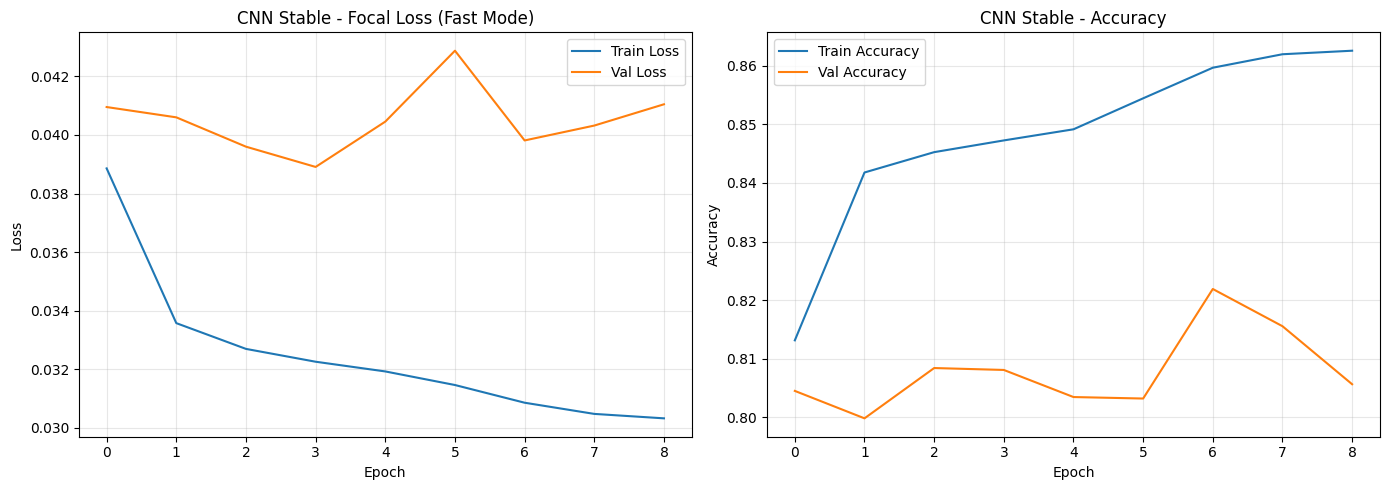

Total epochs trained: 9
Best validation loss: 0.0389

FAST TRAINING SUMMARY
Optimizations applied:
Higher initial learning rates (2x)
Larger batch sizes (512 vs 256)
Reduced max epochs (30 vs 50)
Aggressive early stopping (patience=5)
Data subsampling for quick iteration

Note: LSTM removed due to excessive training time (7.5+ hours)
For sequential patterns, use XGBoost/LightGBM with lag features.


In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_cnn.history['loss'], label='Train Loss')
axes[0].plot(history_cnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('CNN Stable - Focal Loss (Fast Mode)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_cnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('CNN Stable - Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total epochs trained: {len(history_cnn.history['loss'])}")
print(f"Best validation loss: {min(history_cnn.history['val_loss']):.4f}")

print("\n" + "="*60)
print("FAST TRAINING SUMMARY")
print("="*60)
print("Optimizations applied:")
print("Higher initial learning rates (2x)")
print("Larger batch sizes (512 vs 256)")
print("Reduced max epochs (30 vs 50)")
print("Aggressive early stopping (patience=5)")
print("Data subsampling for quick iteration")
print("\nNote: LSTM removed due to excessive training time (7.5+ hours)")
print("For sequential patterns, use XGBoost/LightGBM with lag features.")
print("="*60)

In [13]:
# ============================================================
# Model Evaluation on Test Set
# ============================================================
print("=" * 60)
print("Evaluating Models on Test Set")
print("=" * 60)

available_mem = psutil.virtual_memory().available / 1024**3
print(f"\nAvailable memory: {available_mem:.2f} GB")


# Load models back if they were freed from memory
if 'ffnn_residual' not in dir():
    print("Loading FFNN model...")
    ffnn_residual = load_model(
        MODEL_DIR / "final_ffnn_residual.keras", 
        custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
    )

if 'cnn_stable' not in dir():
    print("Loading CNN model...")
    cnn_stable = load_model(
        MODEL_DIR / "final_cnn_stable.keras",
        custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
    )

# FFNN Residual
print("\n--- FFNN Residual ---")
eval_start = time.time()
y_pred_ffnn = ffnn_residual.predict(X_test, verbose=0, batch_size=1024)
y_pred_ffnn_classes = np.argmax(y_pred_ffnn, axis=1)
eval_time = time.time() - eval_start

acc_ffnn = accuracy_score(y_test, y_pred_ffnn_classes)
f1_ffnn = f1_score(y_test, y_pred_ffnn_classes, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_ffnn:.4f}")
print(f"Test F1 Score: {f1_ffnn:.4f}")
print(f"Inference time: {eval_time:.2f}s ({len(X_test)/eval_time:.0f} samples/sec)")

# CNN Stable
print("\n--- CNN Stable ---")
eval_start = time.time()
y_pred_cnn = cnn_stable.predict(X_test_cnn, verbose=0, batch_size=1024)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
eval_time = time.time() - eval_start

acc_cnn = accuracy_score(y_test, y_pred_cnn_classes)
f1_cnn = f1_score(y_test, y_pred_cnn_classes, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_cnn:.4f}")
print(f"Test F1 Score: {f1_cnn:.4f}")
print(f"Inference time: {eval_time:.2f}s ({len(X_test)/eval_time:.0f} samples/sec)")

# Detailed classification report for best model
best_model_name = "FFNN Residual" if f1_ffnn > f1_cnn else "CNN Stable"
best_preds = y_pred_ffnn_classes if f1_ffnn > f1_cnn else y_pred_cnn_classes

print("\n" + "=" * 60)
print(f"Detailed Classification Report - {best_model_name}")
print("=" * 60)
print(classification_report(y_test, best_preds, digits=4))

# Cleanup
del y_pred_ffnn, y_pred_cnn
gc.collect()

Evaluating Models on Test Set

Available memory: 5.22 GB

--- FFNN Residual ---
Test Accuracy: 0.8762
Test F1 Score: 0.8700
Inference time: 83.32s (112065 samples/sec)

--- CNN Stable ---
Test Accuracy: 0.8078
Test F1 Score: 0.7641
Inference time: 253.48s (36836 samples/sec)

Detailed Classification Report - FFNN Residual


d:\project\unified-ids-and-iot-security-system\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\project\unified-ids-and-iot-security-system\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\project\unified-ids-and-iot-security-system\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

              precision    recall  f1-score   support

           0     0.8889    0.0248    0.0483       644
           1     0.8000    0.9763    0.8794    219639
           2     0.9565    0.1502    0.2596      1172
           3     0.8776    0.1922    0.3154      1082
           4     0.9955    0.9859    0.9907     57021
           5     0.8386    0.7416    0.7871      5758
           6     0.9991    0.9992    0.9991   1440101
           7     0.9665    0.9883    0.9773     90498
           8     0.9993    0.9993    0.9993    818951
           9     0.9999    0.9992    0.9996    809057
          10     0.6760    0.9615    0.7939    811838
          11     0.7111    0.8911    0.7910      4685
          12     0.9867    0.7098    0.8257    719628
          13     0.7534    0.9859    0.8541    899533
          14     0.8280    0.9017    0.8633   1082457
          15     0.9946    0.9866    0.9906     57385
          16     0.5923    0.3600    0.4478     35782
          17     0.9295    

2077

In [16]:
print(f"Memory before loading: {get_memory_usage():.2f} GB")
# ---------------- Autoencoder ----------------

# Load dataset
# -------------------------------------------------------------------
print("[INFO] Loading dataset...")
df = pd.read_csv(DATA_DIR / "train_balanced.csv", dtype=np.float32)
labels = pd.read_csv(DATA_DIR / "train_balanced_labels.csv", dtype=np.int16)

if labels.shape[1] == 1:
    labels = labels.iloc[:, 0]

# -------------------------------------------------------------------
# Filter BENIGN (normal) samples only
# -------------------------------------------------------------------
print("[INFO] Filtering BENIGN samples for training...")

benign_mask = labels == 0

X_normal = df[benign_mask]

print(f"[INFO] Normal samples selected: {X_normal.shape[0]}")

# -------------------------------------------------------------------
# Scale features
# -------------------------------------------------------------------
print("[INFO] Scaling data...")
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# Save scaler for inference
joblib.dump(scaler, MODEL_DIR / "anomaly_scaler.joblib")

# -------------------------------------------------------------------
# Build Autoencoder
# -------------------------------------------------------------------
print("\n---------------- Autoencoder (Anomaly Detection) ----------------")

input_dim = X_normal_scaled.shape[1]

autoencoder = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# -------------------------------------------------------------------
# Train Model
# -------------------------------------------------------------------
print("[INFO] Training autoencoder on normal data...")


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_normal_scaled, X_normal_scaled,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------------------------------------------
# Save Model
# -------------------------------------------------------------------
MODEL_PATH = MODEL_DIR / "anomaly_autoencoder.keras"
autoencoder.save(MODEL_PATH)
print(f"[INFO] Saved trained autoencoder to {MODEL_PATH}")

# -------------------------------------------------------------------
# Determine Reconstruction Error Threshold
# -------------------------------------------------------------------
reconstructions = autoencoder.predict(X_normal_scaled)
mse = np.mean(np.power(X_normal_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)

print(f"[INFO] Calculated anomaly threshold (95th percentile): {threshold:.6f}")

np.save(MODEL_DIR / "anomaly_threshold.npy", threshold)



Memory before loading: 3.23 GB
[INFO] Loading dataset...
[INFO] Filtering BENIGN samples for training...
[INFO] Normal samples selected: 2574
[INFO] Scaling data...

---------------- Autoencoder (Anomaly Detection) ----------------


d:\project\unified-ids-and-iot-security-system\myvenv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO] Training autoencoder on normal data...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 616ms/step - loss: 0.9367 - val_loss: 0.7780
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.7543 - val_loss: 0.6014
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6290 - val_loss: 0.5392
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5719 - val_loss: 0.4900
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5317 - val_loss: 0.4650
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5113 - val_loss: 0.4500
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4999 - val_loss: 0.4426
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4930 - val_loss: 0.4372
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4886 - val_loss: 0.4340
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4852 - val_loss: 0.4309
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4820 - val_loss: 0.4283
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 

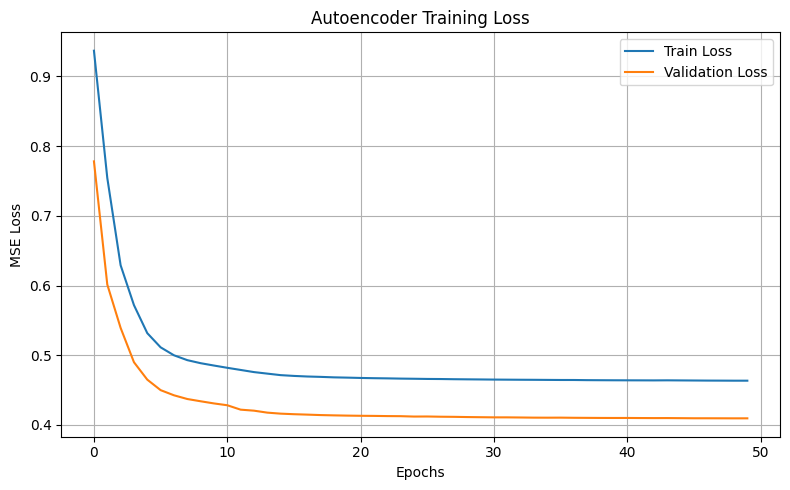


[INFO] Training complete. Model and scaler saved successfully.
Memory after loading: 0.80 GB


In [17]:
# -------------------------------------------------------------------
# Plot Training Loss
# -------------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n[INFO] Training complete. Model and scaler saved successfully.")
print(f"Memory after loading: {get_memory_usage():.2f} GB")